# CUSTOMER RETENTION.

- This project is a Customer Retention & Churn Prediction Pipeline built with Python. Using the Telco Customer Churn dataset (from Kaggle), it analyzes customer purchase and subscription history to:

- Understand retention trends (tenure, monthly charges, contracts, payment methods).

- Apply predictive modeling (Gradient Boosting and LightGBM) to forecast churn probability.

- Use EDA and retention plots (tenure vs churn, charges distributions, survival curves) to explain why customers leave.

- Provide actionable insights so businesses can reduce churn and improve retention strategies.

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


# EDA

In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df.shape

(7043, 21)

In [8]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [9]:
df.duplicated().value_counts()

False    7043
Name: count, dtype: int64

In [10]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [13]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

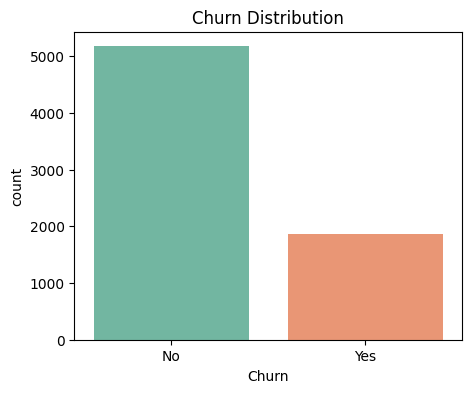

In [14]:
plt.figure(figsize=(5,4))
sn.countplot(x=df["Churn"], data=df, palette="Set2")
plt.title("Churn Distribution")

plt.show()

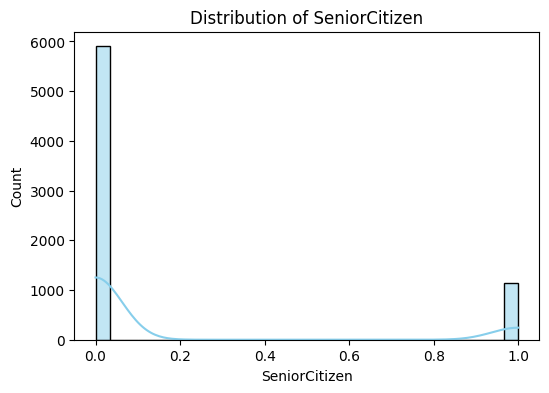

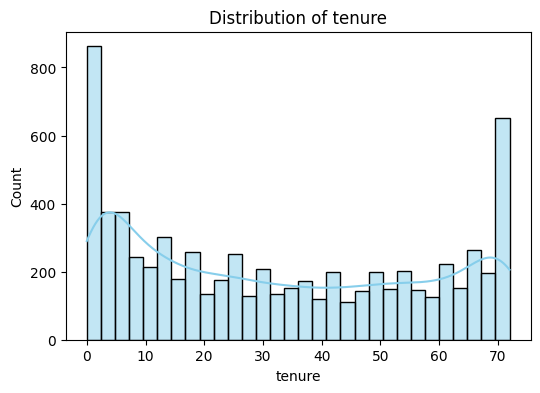

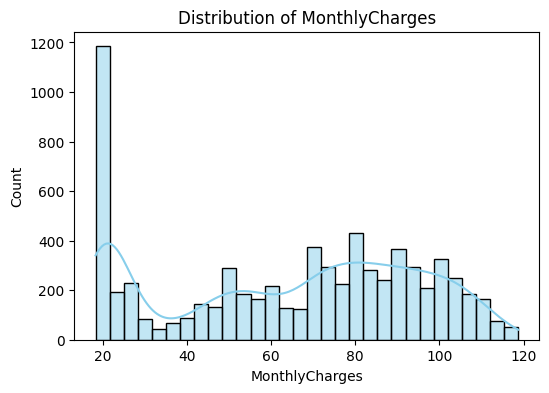

In [15]:
# Numeric Distributions
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sn.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}")
    
    plt.show()

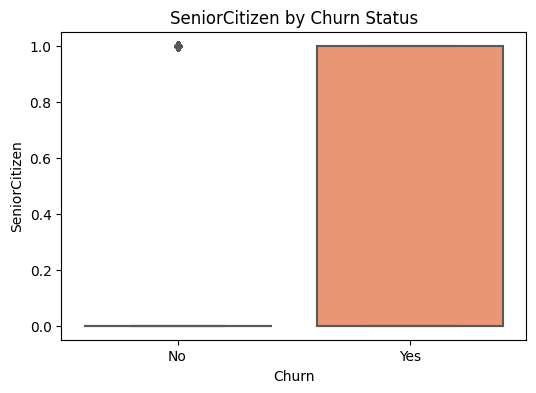

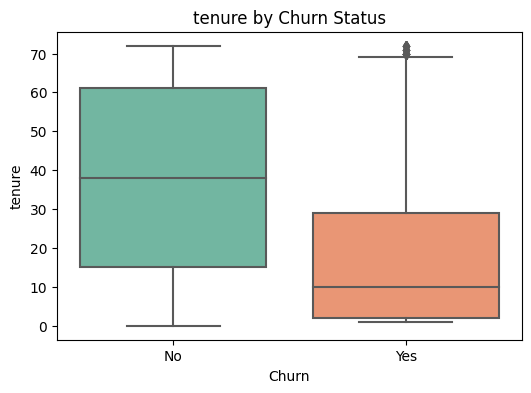

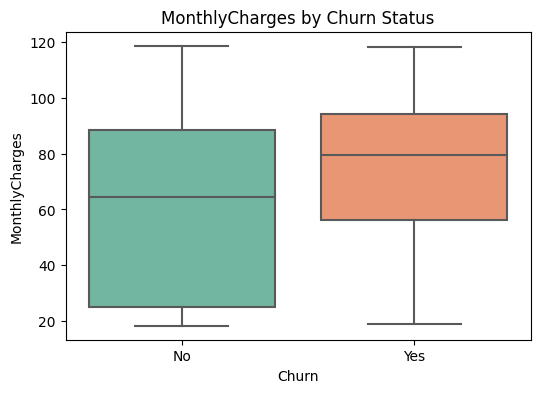

In [16]:
# Churn vs Numerical Features
for col in num_cols:
    plt.figure(figsize=(6,4))
    sn.boxplot(x=df["Churn"], y=col, data=df, palette="Set2")
    plt.title(f"{col} by Churn Status")
    
    plt.show()

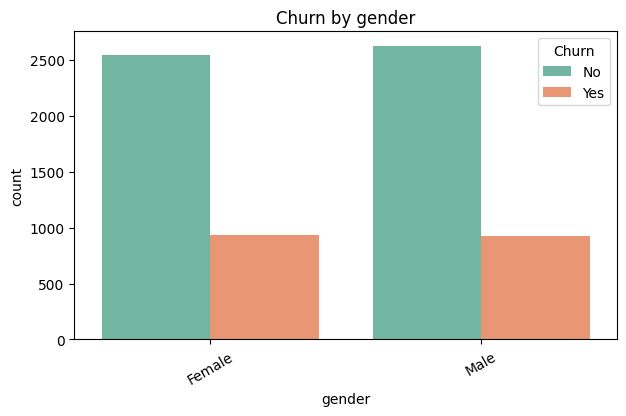

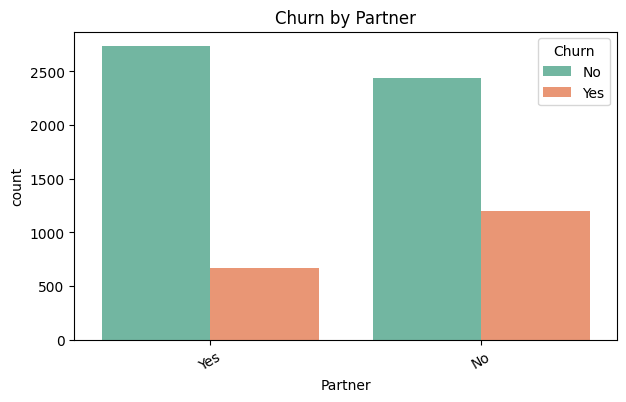

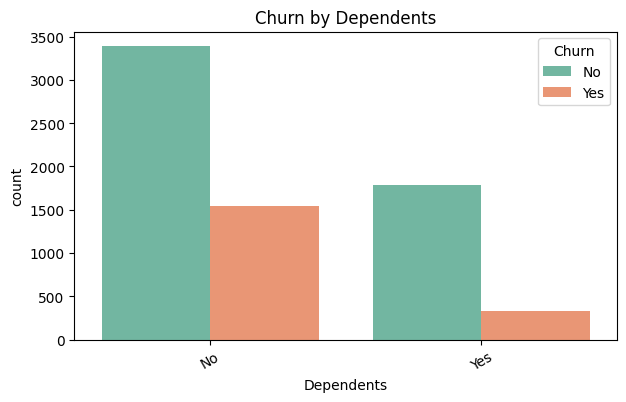

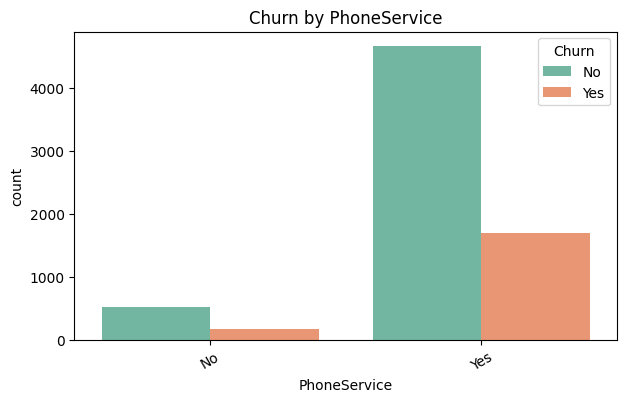

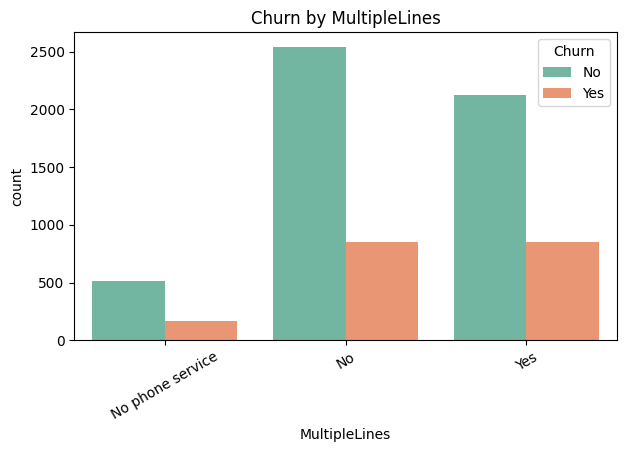

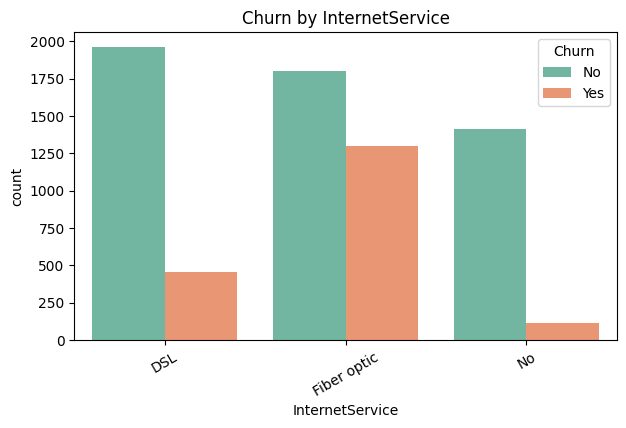

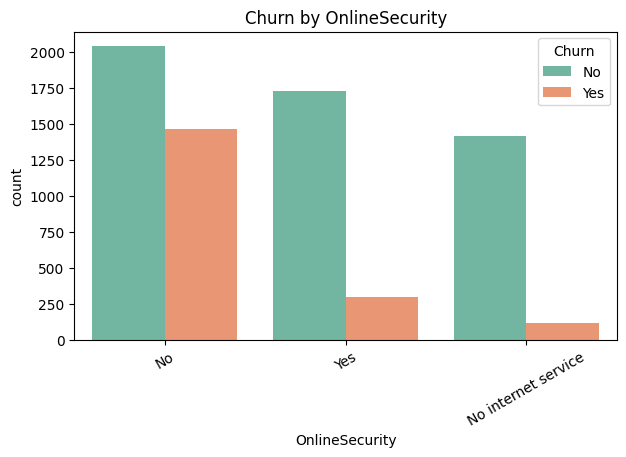

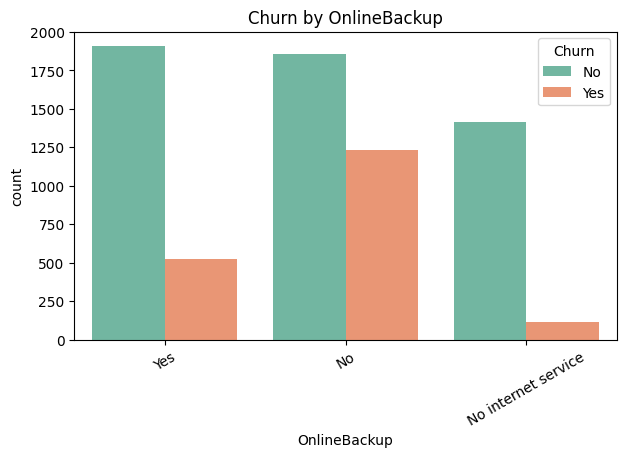

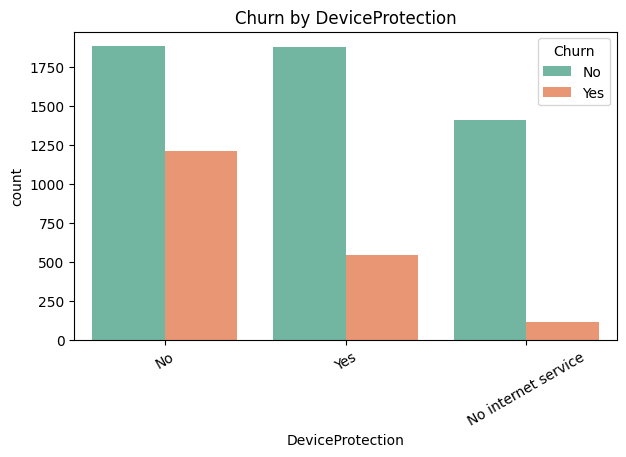

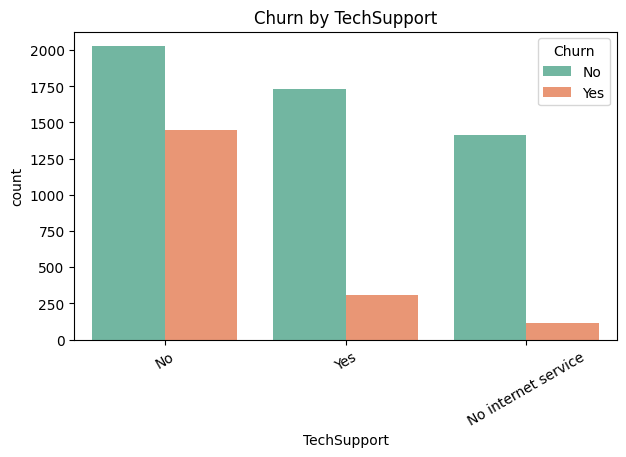

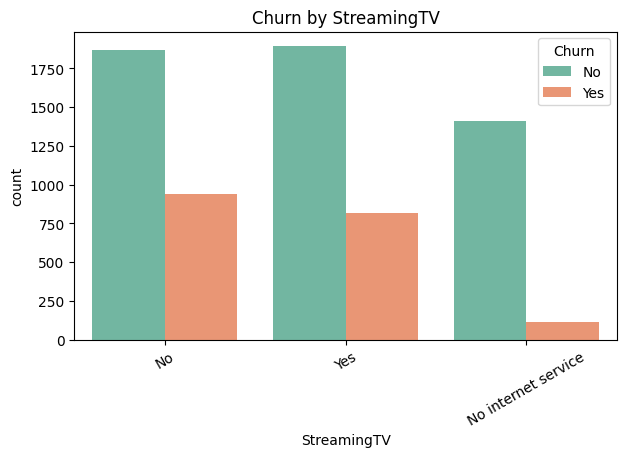

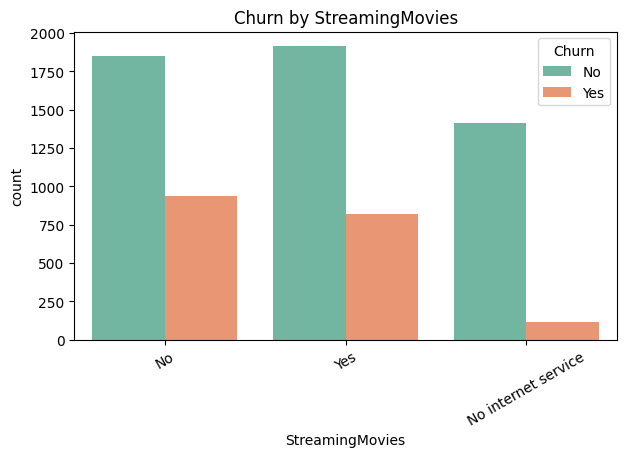

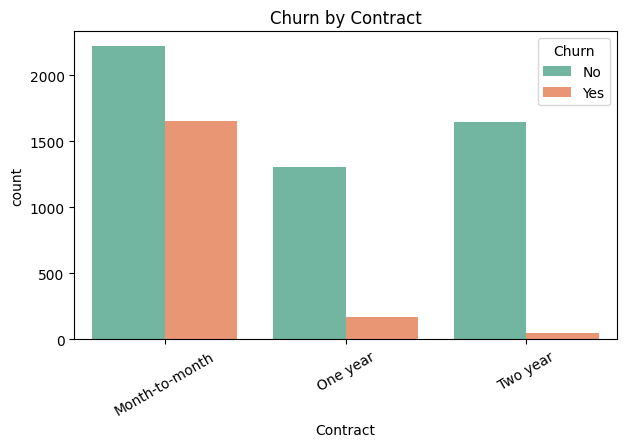

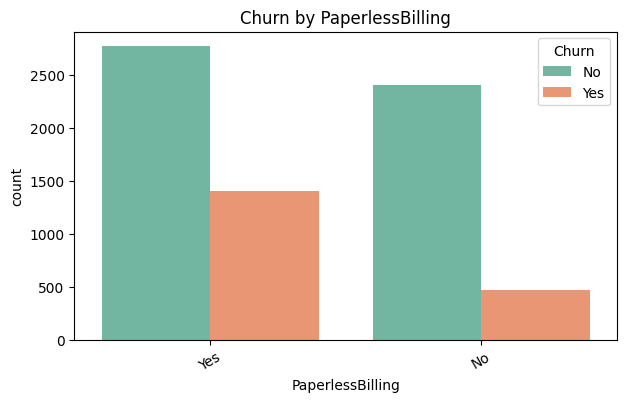

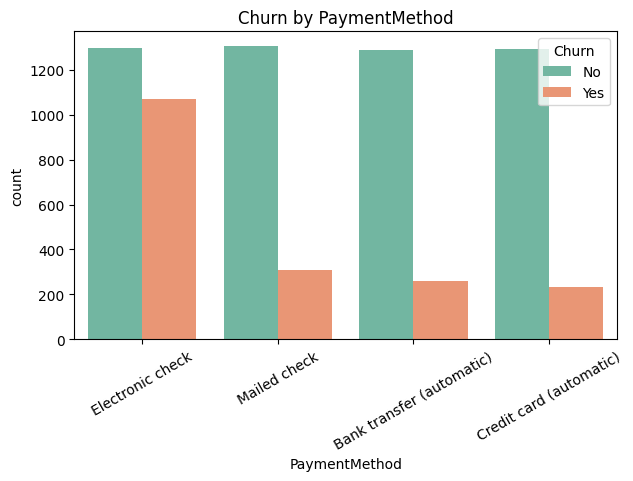

In [17]:
# Churn vs Categorical Features
cat_cols = df.select_dtypes(include=["object", "category"]).columns
cat_cols = [c for c in cat_cols if c != "Churn"]

for col in cat_cols:
    if df[col].nunique() < 10:  # skip high-cardinality features
        plt.figure(figsize=(7,4))
        sn.countplot(x=col, hue="Churn", data=df, palette="Set2")
        plt.title(f"Churn by {col}")
        plt.xticks(rotation=30)
        
        plt.show()

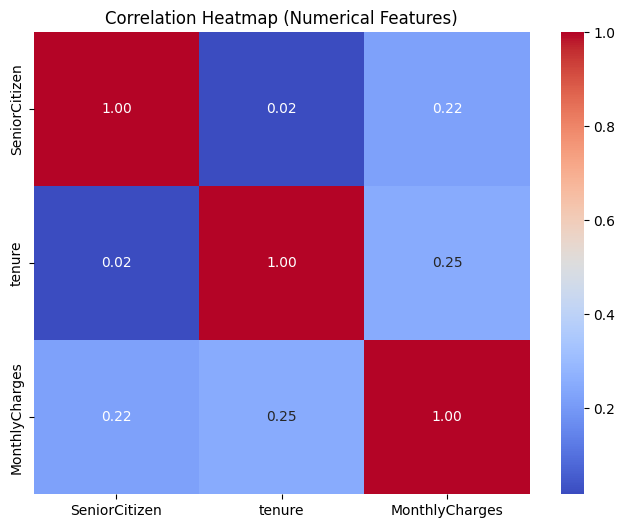

In [18]:
# Correlation Heatmap
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    sn.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (Numerical Features)")
    
    plt.show()

<Figure size 700x500 with 0 Axes>

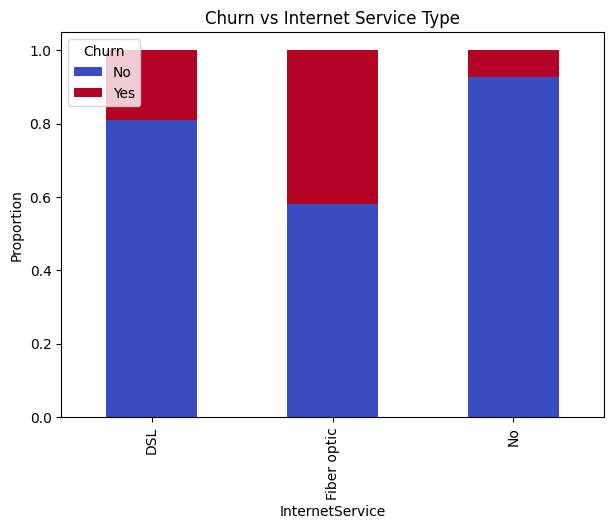

In [45]:
# Stacked Bar Plot (Churn vs Internet Service)
plt.figure(figsize=(7,5))
pd.crosstab(df["InternetService"], df["Churn"]).apply(lambda r: r/r.sum(), axis=1).plot(
    kind="bar", stacked=True, figsize=(7,5), colormap="coolwarm"
)
plt.title("Churn vs Internet Service Type")
plt.ylabel("Proportion")

plt.show()

# Data Cleaning

In [19]:
# Convert TotalCharges Column To Int
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Feature Engineering

In [20]:
df2 = df.copy()

In [21]:
df2["tenure_group"] = pd.cut(df2["tenure"], bins=[0, 12, 24, 48, 72, 100], labels=["0-12","13-24","25-48","49-72","72+"])

# Convert to numeric codes
df2["tenure_group"] = df2["tenure_group"].cat.codes

In [22]:
# Drop columns not useful
drop_cols = ["customerID"] if "customerID" in df2.columns else []
df2 = df2.drop(columns=drop_cols)

In [23]:
binary_cols = df2.select_dtypes(include="object")

binary_cols = binary_cols.drop(["gender", "MultipleLines", "InternetService", "PaymentMethod", "Churn"], axis= 1)

In [24]:
# Encode binary/categorical
for col in binary_cols:
    if col in df2.columns:
        df2[col] = df2[col].map({"Yes":1, "No":0})

In [25]:
# One-hot for other categorical
cat_cols = [c for c in df2.columns if df2[c].dtype == "object" and c not in binary_cols and c not in ["Churn"]]
df2 = pd.get_dummies(df2, columns=cat_cols, drop_first=True, dtype=int)

In [26]:
# Scale numeric
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
df2[num_cols] = scaler.fit_transform(df2[num_cols])

In [27]:
df2.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Churn,tenure_group,gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,-1.277445,0,0.0,1.0,0.0,0.0,0.0,...,No,0,0,1,0,0,0,0,1,0
1,0,0,0,0.066327,1,1.0,0.0,1.0,0.0,0.0,...,No,2,1,0,0,0,0,0,0,1
2,0,0,0,-1.236724,1,1.0,1.0,0.0,0.0,0.0,...,Yes,0,1,0,0,0,0,0,0,1
3,0,0,0,0.514251,0,1.0,0.0,1.0,1.0,0.0,...,No,2,1,1,0,0,0,0,0,0
4,0,0,0,-1.236724,1,0.0,0.0,0.0,0.0,0.0,...,Yes,0,0,0,0,1,0,0,1,0


In [28]:
df2.isna().sum()

SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
OnlineSecurity                           1526
OnlineBackup                             1526
DeviceProtection                         1526
TechSupport                              1526
StreamingTV                              1526
StreamingMovies                          1526
Contract                                 7043
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
tenure_group                                0
gender_Male                                 0
MultipleLines_No phone service              0
MultipleLines_Yes                           0
InternetService_Fiber optic                 0
InternetService_No                

In [29]:
X = df2.drop(columns=["Churn"], axis=1)
y = df2["Churn"].map({"Yes": 1, "No": 0})

In [30]:
X.shape, y.shape

((7043, 24), (7043,))

In [31]:
X.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'tenure_group', 'gender_Male',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [32]:
# Split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)                                            

# Create Model

In [33]:
models = {
        "histGradient_boosting": HistGradientBoostingClassifier(),
        "lightgbm": LGBMClassifier(n_estimators=100, random_state=42)
}

In [34]:
# Dictionary to collect results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Print detailed report
    print(f"\n=== Model: {name} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    
    if auc is not None:
        print("ROC AUC:", auc)
    
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC AUC": auc
    })


=== Model: histGradient_boosting ===
Accuracy: 0.794889992902768
Precision: 0.6384364820846905
Recall: 0.5240641711229946
F1: 0.5756240822320117
ROC AUC: 0.8233382417525639
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409

Confusion matrix:
 [[924 111]
 [178 196]]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number o

In [35]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

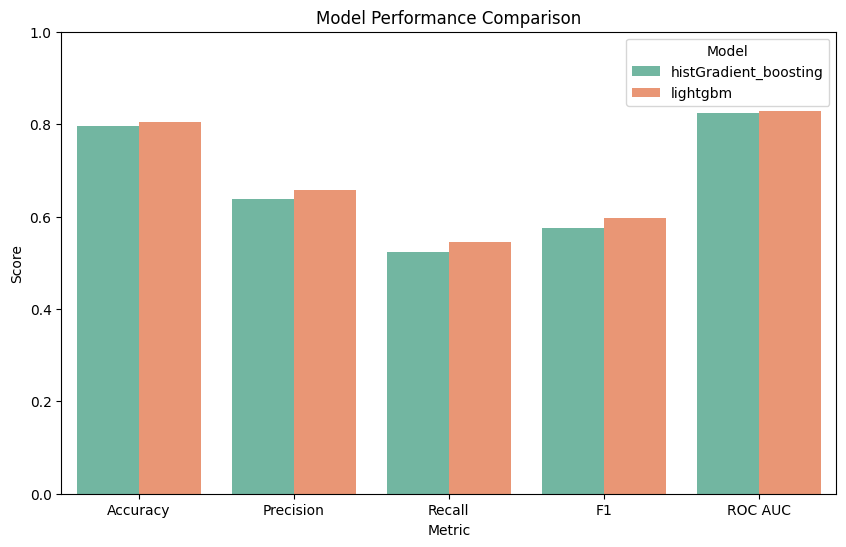

In [36]:
# --- Plotting ---
plt.figure(figsize=(10,6))
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sn.barplot(x="Metric", y="Score", hue="Model", data=results_melted, palette="Set2")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(title="Model")

plt.show()

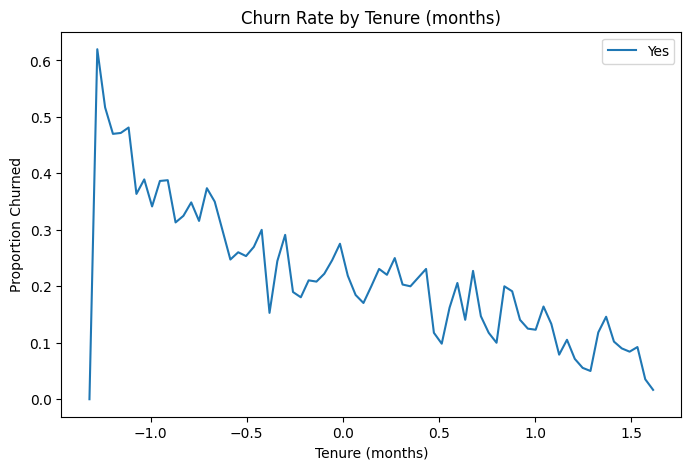

In [37]:
# Churn rate by tenure month
churn_by_tenure = df2.groupby("tenure")["Churn"].value_counts(normalize=True).unstack().fillna(0)
churn_by_tenure.plot(kind="line", y="Yes", figsize=(8,5))
plt.title("Churn Rate by Tenure (months)")
plt.ylabel("Proportion Churned")
plt.xlabel("Tenure (months)")

plt.show()

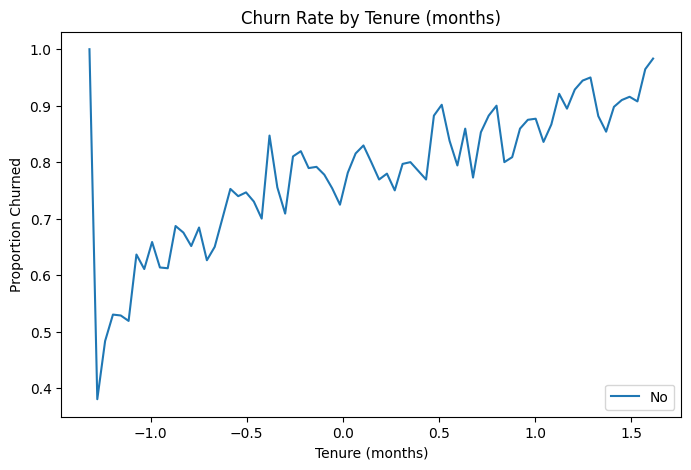

In [38]:
# Churn rate by tenure month
churn_by_tenure = df2.groupby("tenure")["Churn"].value_counts(normalize=True).unstack().fillna(0)
churn_by_tenure.plot(kind="line", y="No", figsize=(8,5))
plt.title("Churn Rate by Tenure (months)")
plt.ylabel("Proportion Churned")
plt.xlabel("Tenure (months)")

plt.show()

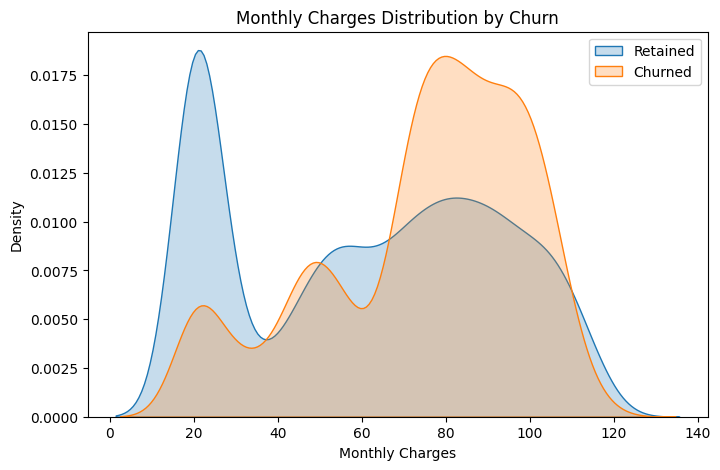

In [39]:
# Monthly Charges Distribution by Churn
plt.figure(figsize=(8,5))
sn.kdeplot(df[df["Churn"]=="No"]["MonthlyCharges"], label="Retained", shade=True)
sn.kdeplot(df[df["Churn"]=="Yes"]["MonthlyCharges"], label="Churned", shade=True)
plt.title("Monthly Charges Distribution by Churn")
plt.xlabel("Monthly Charges")
plt.legend()

plt.show()

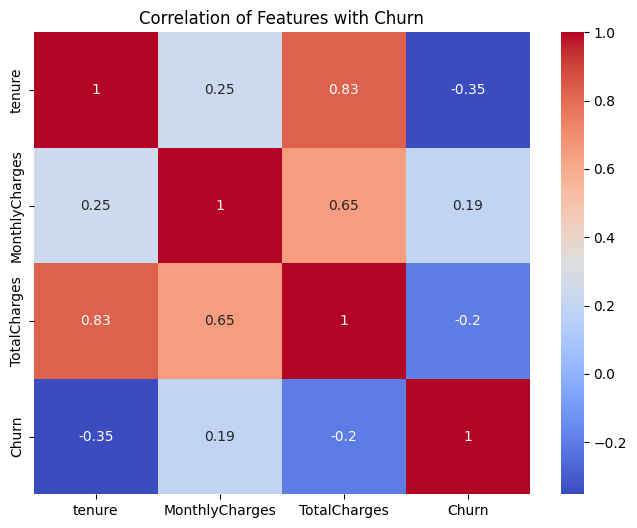

In [40]:
# Heatmap of Correlation Between Numeric Features & Churn
plt.figure(figsize=(8,6))
num_cols = ["tenure","MonthlyCharges","TotalCharges"]
corr = df[num_cols + ["Churn"]].copy()
corr["Churn"] = corr["Churn"].map({"Yes":1, "No":0})
sn.heatmap(corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Churn")

plt.show()

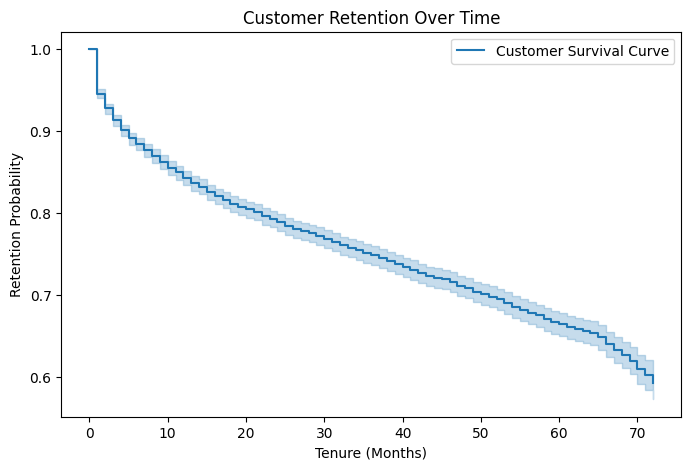

In [42]:
# Survival Curve (Retention over Time)
# Using lifelines library:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(8,5))

T = df["tenure"]   # time (months subscribed)
E = df["Churn"].map({"Yes":1, "No":0})   # event (churn=1)

kmf.fit(T, event_observed=E, label="Customer Survival Curve")
kmf.plot_survival_function()
plt.title("Customer Retention Over Time")
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Probability")
plt.show()